# XGBoost

##### In this project, using the in-situ CPT data completed on different tailings from different dam sites, the liquifaction potential of material were estimated. Liquefaction potential refers to the likelihood that a soil will lose strength and behave like a liquid when subjected to stress typically during earthquake shaking or other rapid loading. The key inputs for this assessments are cone tip resistence (qt), sleeve friction (fs), Friction ratio (FR%), and classification of tailings. 

## Importing the libraries

In [5]:
#!pip install xgboost

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the dataset

In [8]:
# Load your data
df = pd.read_excel("All_Cleaned_Summary.xlsx")
df.shape
#df.head()

(16000, 16)

In [9]:
required_cols = ['Liquified? (Y/N)', 'qt (MPa)', 'FR (%)', 'fs (MPa)', 'USGS Class.']
df = df.dropna(subset=required_cols)

# Encode target variable
df['Liquified'] = df['Liquified? (Y/N)'].map({'Y': 1, 'N': 0})

# One-hot encode USGS Class
df['USGS Class.'] = df['USGS Class.'].fillna('Unknown')
df_encoded = pd.get_dummies(df, columns=['USGS Class.'])

# Define features and target
selected_features = ['qt (MPa)', 'FR (%)', 'fs (MPa)'] + [col for col in df_encoded.columns if col.startswith('USGS Class.')]
X = df_encoded[selected_features]
y = df_encoded['Liquified']

## Splitting the dataset into the Training set and Test set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
X_test.head()

,qt (MPa),FR (%),fs (MPa),USGS Class._CL,USGS Class._GP-SP,USGS Class._ML-CL,USGS Class._SM,USGS Class._SP-ML
8756,4.892759,1.112697,0.054442,False,False,False,True,False
4660,2.369925,2.012300,0.047690,False,False,False,True,False
6095,4.287281,3.546303,0.152040,False,False,False,True,False
304,2.990148,1.819308,0.054400,False,False,False,True,False
8241,1.488341,1.111750,0.016547,False,False,True,False,False


## Training XGBoost on the Training set

In [13]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/Volumes/Mac/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:49:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [14]:
y_pred = model.predict(X_test)

In [15]:
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy Score: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1406
           1       0.88      0.89      0.89      1794

    accuracy                           0.87      3200
   macro avg       0.87      0.87      0.87      3200
weighted avg       0.87      0.87      0.87      3200



## Making the Confusion Matrix

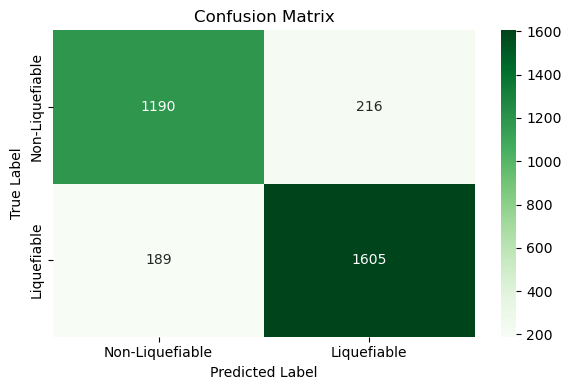

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Liquefiable', 'Liquefiable'],
            yticklabels=['Non-Liquefiable', 'Liquefiable'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('reduced_feature.png')
plt.show()

In [18]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")

Accuracy Score: 0.87


In [19]:
from sklearn.metrics import precision_score

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision Score: {precision:.2f}")

Precision Score: 0.88


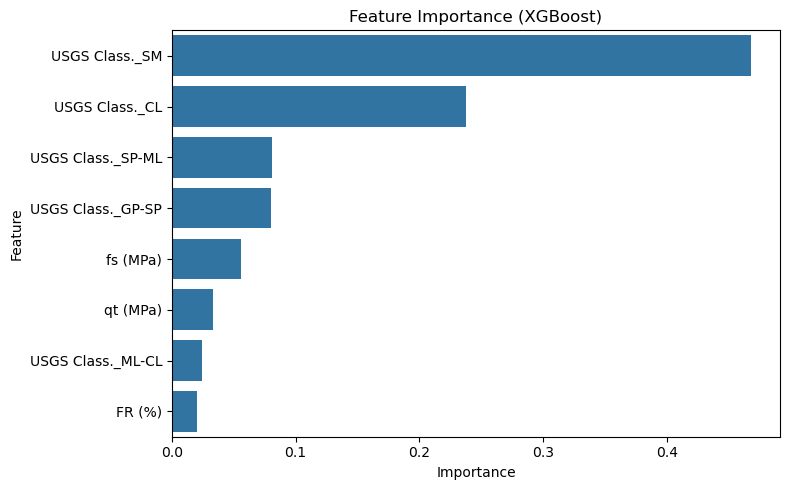

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming model is your trained XGBoost model
importances = model.feature_importances_
features = X.columns

# Create a DataFrame for plotting
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

### Test the model on user's Input

In [37]:
print([col for col in df_encoded.columns if col.startswith("USGS Class.")])

['USGS Class._CL', 'USGS Class._GP-SP', 'USGS Class._ML-CL', 'USGS Class._SM', 'USGS Class._SP-ML']


In [45]:
# Enter your input
custom_input = {
    'qt (MPa)': 1.5,
    'FR (%)': 60,
    'fs (MPa)': 0.1,
    'USGS Class._CL': 0,
    'USGS Class._GP-SP': 1,			
    'USGS Class._ML-CL': 0,
    'USGS Class._SM': 0,
    'USGS Class._SP-ML':0
    # Add all other one-hot encoded USGS Class columns with 0 or 1
}

# Convert to DataFrame and ensure the same column order as training
import pandas as pd
custom_df = pd.DataFrame([custom_input])

# Reorder columns to match training set
custom_df = custom_df[X.columns]

# Predict using your trained model
prediction = model.predict(custom_df)  # assuming your trained model is called 'model'

# Output result
print("Prediction:", "Liquefied" if prediction[0] == 1 else "Not Liquefied")

Prediction: Not Liquefied
